In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9

In [3]:
# LOAD BOMBUS VISIT DATA WITH INTERVALS AND SPECIES ID, LIMIT TO CLOVER PERIOD
df = pd.read_csv('csvs/bombus_visit_durations.csv', parse_dates=["visit_start", "visit_end"])
bombus_visits_clover = df[df['visit_end'] < pd.Timestamp('2024-07-30')]

In [4]:
bombus_visits_clover.value_counts('species')

species
vosnesenskii    173
fervidus         70
unk              31
griseocollis     13
nevadensis        2
appositus         1
mixtus            1
Name: count, dtype: int64

In [5]:
# PIVOT TO WIDE FORMAT OF COUNTS PER COLOR, COLS ARE COLORS
species_col_visits = pd.DataFrame(bombus_visits_clover[bombus_visits_clover['species'] != 'unk'].groupby(['species', 'color']).size()).reset_index()

species_col_visits.columns = ['species', 'color', 'visit_count']
species_col_wide = species_col_visits.pivot_table(
    index='species',
    columns='color',
    values='visit_count',
    fill_value=0
)

order = ['appositus', 'mixtus', 'nevadensis', 'griseocollis', 'fervidus', 'vosnesenskii']
# color_order = ['cnt', 'blv', 'grn', 'blu', 'yel']
color_order = ['yel','blu', 'grn','blv','cnt']
species_col_wide = species_col_wide[color_order]
species_col_wide = species_col_wide.reindex(order)

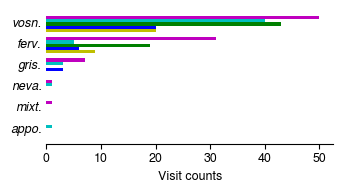

In [6]:
# PLOT SPECIES COUNTS PER STIMULUS TYPE
colors = species_col_wide.columns
species = ['appo', 'mixt', 'neva', 'gris', 'ferv', 'vosn']

color_map = {
    'blu': 'b',
    'blv': 'c',
    'cnt': 'm',
    'grn': 'g',
    'yel': 'y'
}

x = np.arange(len(species))
width = 0.15 

fig, ax = plt.subplots(figsize=(3.5, 2))
for i, color in enumerate(colors):
    ax.barh(x + i * width, species_col_wide[color], width, color=color_map[color])

ax.set_xlabel('Visit counts')
# ax.set_ylabel(r'$\it{Bombus}$ species')

ax.set_yticks(x + width * len(colors) / 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([f"{label}." for label in species], style='italic')

plt.tight_layout()
plt.savefig('figs/stimulus_species_counts_smaller.svg', format='svg')

In [7]:
# LOAD SPECIES COUNTS FOR CAMERA TRAPS, BLUE VANE TRAPS, AND HAND NETTING
cam_bombus_counts = bombus_visits_clover['species'].value_counts()

survey_data = pd.read_csv('csvs/Clover_Bee_occurrence_data.csv')
bvt_data  = survey_data[survey_data['Collection method'] == 'vane trap'].reset_index(drop=True)
net_data  = survey_data[survey_data['Collection method'] == 'net'].reset_index(drop=True)

bvt_taxa = bvt_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
bvt_bombus_counts = bvt_taxa[bvt_taxa['Genus'] == 'Bombus']['Species'].value_counts()

net_taxa = net_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
net_bombus_counts = net_taxa[net_taxa['Genus'] == 'Bombus']['Species'].value_counts()

species_all = list(set(cam_bombus_counts.index).union(bvt_bombus_counts.index, net_bombus_counts.index))

species_all = [
 'caliginosus',
 'mixtus',
 'appositus',
 'nevadensis',
 'griseocollis',
 'fervidus',
 'vosnesenskii']

counts_s1 = [cam_bombus_counts[species] if species in cam_bombus_counts.index else 0 for species in species_all]
counts_s2 = [bvt_bombus_counts[species] if species in bvt_bombus_counts.index else 0 for species in species_all]
counts_s3 = [net_bombus_counts[species] if species in net_bombus_counts.index else 0 for species in species_all]
counts_s1_cnt = [species_col_wide['cnt'][species] if species in cam_bombus_counts.index else 0 for species in species_all]

# NORMALIZE COUNTS TO EFFORT
counts_s1n = [round(x/180, 2) for x in counts_s1] # PER TRAP DAY
counts_s2n = [round(x/16, 2) for x in counts_s2] # PER TRAP DAY
counts_s3n = [round(x/50, 2) for x in counts_s3] # PER SAMPLING MINUTE

df_counts = pd.DataFrame({
    'Species': species_all,
    'Camera': counts_s1,
    'BVT': counts_s2,
    'Net': counts_s3
})

# df_counts.to_csv('method_comparison_fig/sample_method_counts.csv', index=False)

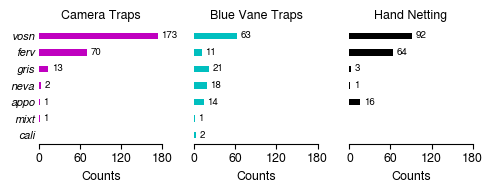

In [8]:
# PLOT METHODS COMPARISON
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  

fig, axs = plt.subplots(1, 3, figsize=(5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Counts', size=9)
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1)), height=bar_width, color='m')
for bar, count in zip(bars0, list(reversed(counts_s1))):
    if count != 0:
        axs[0].text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2)), height=bar_width, color='c')
for bar, count in zip(bars1, list(reversed(counts_s2))):
    if count != 0:
        axs[1].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Counts', size=9)
axs[1].set_title('Blue Vane Traps', size=9)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3))):
    if count != 0:
        axs[2].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Counts', size=9)
axs[2].set_title('Hand Netting', size=9)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, 180)
    ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label[:4] for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
plt.savefig('figs/methods_comparison_separated.svg', format='svg')

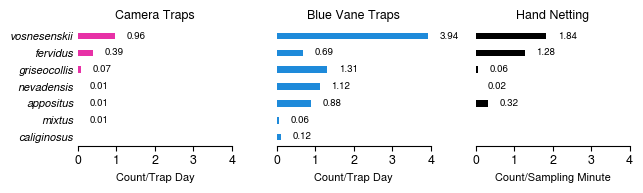

In [9]:
# PLOT METHODS COMPARISON WITH NORMALIZED COUNTS
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  
text_offset = .3

fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Count/Trap Day', size=8)
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1n)), height=bar_width, color='#e731a6ff')
for bar, count in zip(bars0, list(reversed(counts_s1n))):
    if count != 0:
        axs[0].text(
            bar.get_width() + text_offset,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2n)), height=bar_width, color='#1e8adaff')
for bar, count in zip(bars1, list(reversed(counts_s2n))):
    if count != 0:
        axs[1].text(bar.get_width() + text_offset, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Count/Trap Day', size=8)
axs[1].set_title('Blue Vane Traps', size=9)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3n)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3n))):
    if count != 0:
        axs[2].text(bar.get_width() + text_offset, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Count/Sampling Minute', size=8)
axs[2].set_title('Hand Netting', size=9)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, 4)
    # ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
# plt.savefig('figs/methods_comparison_separated_norm.svg', format='svg')

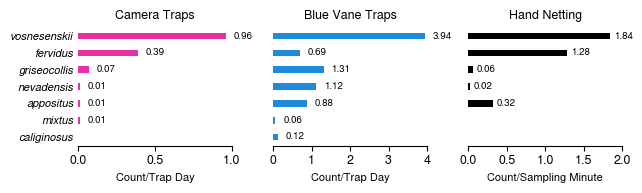

In [10]:
# PLOT METHODS COMPARISON WITH NORMALIZED COUNTS
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  
text_offset = .3

fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Count/Trap Day', size=8)
axs[0].set_xlim(0,1)
axs[0].set_xticks([0,0.5,1])
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1n)), height=bar_width, color='#e731a6ff')
for bar, count in zip(bars0, list(reversed(counts_s1n))):
    if count != 0:
        axs[0].text(
            bar.get_width() + .05,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2n)), height=bar_width, color='#1e8adaff')
for bar, count in zip(bars1, list(reversed(counts_s2n))):
    if count != 0:
        axs[1].text(bar.get_width() + .2, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Count/Trap Day', size=8)
axs[1].set_title('Blue Vane Traps', size=9)
axs[1].set_xlim(0,4)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3n)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3n))):
    if count != 0:
        axs[2].text(bar.get_width() + .05, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
        
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Count/Sampling Minute', size=8)
axs[2].set_title('Hand Netting', size=9)
axs[2].set_xlim(0,2)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    # ax.set_xlim(0, 4)
    # ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
plt.savefig('figs/methods_comparison_separated_norm_edit.svg', format='svg')

In [11]:
# # PREP AND EXPORT ABUNDANCE COUNTS FOR iNEXT
# cam_bombus_counts = cam_bombus_counts.to_frame()
# cam_abund = cam_bombus_counts.sum(axis=1).to_dict()
# cam_abund.pop('unk')
# bvt_bombus_counts = bvt_bombus_counts.to_frame()
# bvt_abund = bvt_bombus_counts.sum(axis=1).to_dict()
# net_bombus_counts = net_bombus_counts.to_frame()
# net_abund = net_bombus_counts.sum(axis=1).to_dict()

# abundance_list = {
#     "camera": cam_abund,
#     "bvt": bvt_abund,
#     "net": net_abund
# }

# abundance_list_norm = {
#     "camera": [int(x*100) for x in counts_s1n],
#     "bvt": [int(x*100) for x in counts_s2n],
#     "net": [int(x*100) for x in counts_s3n]
# }

# import json

# all_species = set()
# for method_data in abundance_list.values():
#     all_species.update(method_data.keys())
# all_species = sorted(all_species)

# inext_ready = {
#     method: [method_data.get(species, 0) for species in all_species]
#     for method, method_data in abundance_list.items()
# }

# with open("csvs/abundance_list.json", "w") as f:
#     json.dump(inext_ready, f)

# with open("csvs/abundance_list_norm.json", "w") as f:
#     json.dump(abundance_list_norm, f)



In [12]:
# EXPORT TO R
inext_ready = [counts_s1_cnt, counts_s2, counts_s3]

%load_ext rpy2.ipython
%R -i inext_ready

In [13]:
%%R
library(iNEXT)

out_df <- iNEXT(inext_ready, q = c(0,1,2), datatype = "abundance", nboot=1000)
asy_est <- out_df$AsyEst
datainfo <- out_df$DataInfo
size_est <- out_df$iNextEst$size_based
coverage_est <- out_df$iNextEst$coverage_based

In [14]:
%R -o datainfo
%R -o asy_est
%R -o size_est
%R -o coverage_est

In [15]:
div_dict = {"Species richness":0, "Shannon diversity":1, "Simpson diversity":2}
assem_dict = {"assemblage1":"cam", "assemblage2":"bvt", "assemblage3":"net"}
asy_est['Diversity'] = asy_est['Diversity'].replace(div_dict)

for dataframe in [asy_est, datainfo, size_est, coverage_est]:
    dataframe['Assemblage'] = dataframe['Assemblage'].replace(assem_dict)

In [16]:
coverage_est.columns

Index(['Assemblage', 'SC', 'm', 'Method', 'Order.q', 'qD', 'qD.LCL', 'qD.UCL'], dtype='object')

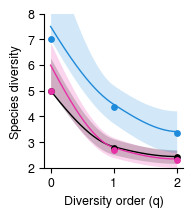

In [17]:
import numpy as np
from scipy.interpolate import PchipInterpolator

method_color_map = {'cam':'#e731a6ff', 'bvt':'#1e8adaff', 'net':'k'}
order = ["net", "cam", "bvt"] 

fig, ax = plt.subplots(figsize=(2,2.25))

for assemblage in order:
    subdf = asy_est[asy_est["Assemblage"] == assemblage]
    x = subdf["Diversity"].values.astype(float)
    y = subdf["Estimator"].values.astype(float)
    lcl = subdf["LCL"].values.astype(float)
    ucl = subdf["UCL"].values.astype(float)
    obs = subdf["Observed"].values.astype(float)

    color = method_color_map.get(assemblage, "k")
    x_smooth = np.linspace(x.min(), x.max(), 200)
    f_est = PchipInterpolator(x, y)
    f_lcl = PchipInterpolator(x, lcl)
    f_ucl = PchipInterpolator(x, ucl)

    y_smooth = f_est(x_smooth)
    lcl_smooth = f_lcl(x_smooth)
    ucl_smooth = f_ucl(x_smooth)

    ax.plot(x_smooth, y_smooth, color=color, linewidth=1)
    ax.fill_between(x_smooth, lcl_smooth, ucl_smooth, color=color, alpha=0.2, linewidth=0)
    # ax.plot(x, obs, color=color, linestyle=":", alpha=1, label=f"{assemblage} (Observed)", marker='o', markersize=3, zorder=4)
    # ax.scatter(x, obs, edgecolor=color, facecolor='none', marker='o', s=15, zorder=4)
    ax.scatter(x, obs, color=color, marker='o', s=15, zorder=4)

ax.set_xlabel("Diversity order (q)")
ax.set_ylabel("Species diversity")
ax.set_xticks([0,1,2], labels=[0,1,2])
ax.set_ylim(2,8)


plt.tight_layout()
plt.savefig('figs/asyest_methods.svg', format='svg')


In [18]:
size_est.columns

Index(['Assemblage', 'm', 'Method', 'Order.q', 'qD', 'qD.LCL', 'qD.UCL', 'SC',
       'SC.LCL', 'SC.UCL'],
      dtype='object')

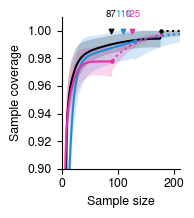

In [29]:
from scipy.optimize import brentq  # root-finding for inverse lookup

fig, ax = plt.subplots(figsize=(2,2.25))
order = ["net", "bvt", "cam"] 
order_q = 0
df_filtered = size_est[size_est['Order.q'] == order_q]

coverage_targets = [0.99]

for assemblage in order:
    subdf = df_filtered[df_filtered["Assemblage"] == assemblage].copy()
    color = method_color_map.get(assemblage, "gray")

    if subdf.empty:
        continue

    subdf = subdf[["Method","m","SC","SC.LCL","SC.UCL"]].dropna()
    subdf = subdf.sort_values("m").drop_duplicates(subset=["m"], keep="last")

    if "Observed" not in subdf["Method"].values:
        continue

    obs_m = subdf[subdf["Method"]=="Observed"]["m"].iloc[0]

    f_y = PchipInterpolator(subdf["m"], subdf["SC"])
    f_lcl = PchipInterpolator(subdf["m"], subdf["SC.LCL"])
    f_ucl = PchipInterpolator(subdf["m"], subdf["SC.UCL"])

    x_smooth = np.linspace(subdf["m"].min(), subdf["m"].max(), 400)
    y_smooth = f_y(x_smooth)
    lcl_smooth = f_lcl(x_smooth)
    ucl_smooth = f_ucl(x_smooth)

    mask_rare = x_smooth <= obs_m
    mask_extra = x_smooth >= obs_m

    ax.plot(x_smooth[mask_rare], y_smooth[mask_rare], color=color, label=assemblage)
    ax.plot(x_smooth[mask_extra], y_smooth[mask_extra], color=color, linestyle="dotted")
    ax.fill_between(x_smooth, lcl_smooth, ucl_smooth, color=color, alpha=0.2, linewidth=0)

    obs = subdf[subdf["Method"] == "Observed"]
    ax.scatter(obs["m"], obs["SC"], color=color, marker="o", s=5, zorder=3)

    for target in coverage_targets:
        try:
            m_target = brentq(lambda xx: f_y(xx) - target, subdf["m"].min(), subdf["m"].max())
            ax.scatter(m_target, 1, color=color, marker="v", zorder=4, linewidths=1, s=10)
            if assemblage == 'bvt':
                ax.text(m_target, target + 0.02, f"{int(round(m_target))}", color=color, fontsize=7, ha="center")
            else:
                ax.text(m_target, target + 0.02, f"{int(round(m_target))}", color=color, fontsize=7, ha="center")
        except ValueError:
            pass


ax.set_ylim(0.90, 1.01)
ax.set_xlim(0,210)
ax.set_xlabel("Sample size")
ax.set_xticks([0,100,200])
ax.set_ylabel("Sample coverage")
plt.tight_layout()
# plt.savefig('figs/coverage_est.svg', format='svg')

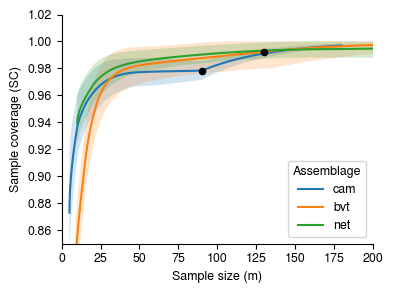

In [20]:

# PARAMETERS
order_q = 0   # choose which q to plot
assemblages = size_est["Assemblage"].unique()

fig, ax = plt.subplots(figsize=(4, 3))

for assemblage in assemblages:
    # Filter data for this assemblage & q
    subdf = size_est[
        (size_est["Order.q"] == order_q) &
        (size_est["Assemblage"] == assemblage)
    ].copy()

    if subdf.empty:
        continue

    # Keep relevant columns
    subdf = subdf[["Method", "m", "SC", "SC.LCL", "SC.UCL"]].dropna(subset=["SC", "m"])

    # Sort by coverage (SC)
    subdf = subdf.sort_values("SC")

    # Drop duplicate SC values (keep largest m for each SC)
    subdf = subdf.drop_duplicates(subset=["SC"], keep="last")

    # Ensure strictly increasing SC (drop non-increasing points)
    subdf = subdf[subdf["SC"].diff().fillna(0) > 0]

    # Need at least 2 points to interpolate
    if len(subdf) < 2:
        continue

    # Build PCHIP interpolators (SC -> m & CIs)
    f_m = PchipInterpolator(subdf["SC"], subdf["m"])
    f_lcl = PchipInterpolator(subdf["SC"], subdf["SC.LCL"])
    f_ucl = PchipInterpolator(subdf["SC"], subdf["SC.UCL"])

    # Build smooth SC grid **inside the loop**
    SC_smooth = np.linspace(subdf["SC"].min(), subdf["SC"].max(), 200)
    m_smooth  = f_m(SC_smooth)
    lcl_smooth = f_lcl(SC_smooth)
    ucl_smooth = f_ucl(SC_smooth)

    # Plot smooth curve
    ax.plot(m_smooth, SC_smooth, label=assemblage)

    # Plot confidence ribbon
    ax.fill_between(m_smooth, lcl_smooth, ucl_smooth, alpha=0.2)

    # Mark observed point (optional)
    obs = subdf[subdf["Method"] == "Observed"]
    if not obs.empty:
        ax.scatter(obs["m"], obs["SC"], color="black", s=20, zorder=5)

# Axis formatting
ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Sample coverage (SC)")
ax.set_ylim(0.85, 1.02)
ax.set_xlim(0, 200)
ax.legend(title="Assemblage")
plt.tight_layout()
plt.show()

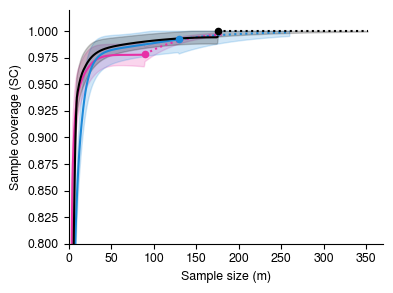

In [21]:
order_q = 0
assemblages = size_est["Assemblage"].unique()
method_color_map = {'cam':'#e731a6ff', 'bvt':'#1e8adaff', 'net':'k'}

fig, ax = plt.subplots(figsize=(4, 3))

for assemblage in assemblages:
    subdf = size_est[
        (size_est["Order.q"] == order_q) &
        (size_est["Assemblage"] == assemblage)
    ].copy()
    if subdf.empty:
        continue

    subdf = subdf[["Method", "m", "SC", "SC.LCL", "SC.UCL"]].dropna()
    subdf = subdf.sort_values("m")
    subdf = subdf.drop_duplicates(subset=["m"], keep="last")

    if len(subdf) < 2:
        continue

    obs = subdf[subdf["Method"] == "Observed"]
    if obs.empty:
        continue

    obs_m = obs["m"].iloc[0]
    color = method_color_map.get(assemblage, "gray")

    f_y = PchipInterpolator(subdf["m"], subdf["SC"])
    f_lcl = PchipInterpolator(subdf["m"], subdf["SC.LCL"])
    f_ucl = PchipInterpolator(subdf["m"], subdf["SC.UCL"])

    x_smooth = np.linspace(subdf["m"].min(), subdf["m"].max(), 400)
    y_smooth = f_y(x_smooth)
    lcl_smooth = f_lcl(x_smooth)
    ucl_smooth = f_ucl(x_smooth)

    mask_rare = x_smooth <= obs_m
    mask_extra = x_smooth >= obs_m

    ax.plot(x_smooth[mask_rare], y_smooth[mask_rare], color=color)
    ax.plot(x_smooth[mask_extra], y_smooth[mask_extra], color=color, linestyle="dotted")
    ax.fill_between(x_smooth, lcl_smooth, ucl_smooth, color=color, alpha=0.2)

    ax.scatter(obs_m, obs["SC"].iloc[0], color=color, s=20, zorder=5)

ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Sample coverage (SC)")
ax.set_ylim(0.8, 1.02)
ax.set_xlim(left=0)
plt.tight_layout()
plt.show()



In [22]:
size_est[size_est['Assemblage'] == 'net']['Method'].unique()

array(['Rarefaction', 'Observed', 'Extrapolation'], dtype=object)

In [23]:
size_est[(size_est['Assemblage'] == 'net') & (size_est['Method'] == 'Observed')]

,Assemblage,m,Method,Order.q,qD,qD.LCL,qD.UCL,SC,SC.LCL,SC.UCL
260,net,176.0,Observed,0.0,5.000000,3.929965,6.070035,1.0,0.994592,1.0
300,net,176.0,Observed,1.0,2.783532,2.496028,3.071037,1.0,0.994592,1.0
340,net,176.0,Observed,2.0,2.415094,2.178777,2.651412,1.0,0.994592,1.0


In [24]:
bad = size_est[
    (size_est["Order.q"] == 0) &
    (size_est["Assemblage"] == "cam")
]

print(bad[["Method", "m", "SC"]])

           Method      m        SC
1     Rarefaction    1.0  0.427216
2     Rarefaction    5.0  0.873021
3     Rarefaction   10.0  0.936226
4     Rarefaction   15.0  0.952622
5     Rarefaction   20.0  0.961709
6     Rarefaction   25.0  0.967742
7     Rarefaction   30.0  0.971747
8     Rarefaction   35.0  0.974321
9     Rarefaction   40.0  0.975906
10    Rarefaction   45.0  0.976833
11    Rarefaction   49.0  0.977264
12    Rarefaction   54.0  0.977561
13    Rarefaction   59.0  0.977698
14    Rarefaction   64.0  0.977754
15    Rarefaction   69.0  0.977773
16    Rarefaction   74.0  0.977777
17    Rarefaction   79.0  0.977778
18    Rarefaction   84.0  0.977778
19    Rarefaction   89.0  0.977778
20       Observed   90.0  0.978266
21  Extrapolation   91.0  0.978744
22  Extrapolation   95.0  0.980552
23  Extrapolation  100.0  0.982597
24  Extrapolation  105.0  0.984427
25  Extrapolation  109.0  0.985752
26  Extrapolation  114.0  0.987250
27  Extrapolation  119.0  0.988591
28  Extrapolation  1

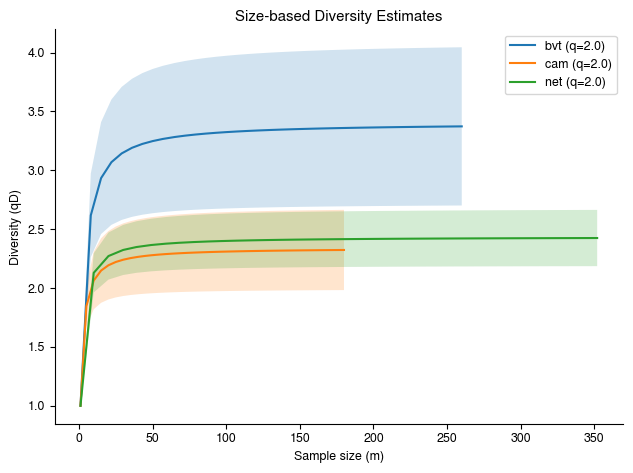

In [25]:
fig, ax = plt.subplots()

q = 2

df_q = size_est[size_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    ax.plot(
        subdf["m"], subdf["qD"], label=f"{assemblage} (q={q})"
    )
    ax.fill_between(
        subdf["m"], subdf["qD.LCL"], subdf["qD.UCL"], alpha=0.2
    )

ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Diversity (qD)")
ax.set_title("Size-based Diversity Estimates")
ax.legend()
plt.tight_layout()

In [26]:
coverage_est

,Assemblage,SC,m,Method,Order.q,qD,qD.LCL,qD.UCL
1,cam,0.427219,1.0,Rarefaction,0.0,1.000007,0.912994,1.087020
2,cam,0.873021,5.0,Rarefaction,0.0,2.321592,1.941291,2.701892
3,cam,0.936226,10.0,Rarefaction,0.0,2.785907,2.245413,3.326401
4,cam,0.952622,15.0,Rarefaction,0.0,3.066804,2.451864,3.681744
5,cam,0.961709,20.0,Rarefaction,0.0,3.283941,2.631933,3.935949
...,...,...,...,...,...,...,...,...
296,net,0.993864,146.0,Rarefaction,2.0,2.411088,2.173964,2.648212
297,net,0.994105,155.0,Rarefaction,2.0,2.412451,2.175375,2.649527
298,net,0.994268,165.0,Rarefaction,2.0,2.413793,2.176817,2.650769
299,net,0.994318,174.0,Rarefaction,2.0,2.414923,2.178544,2.651301


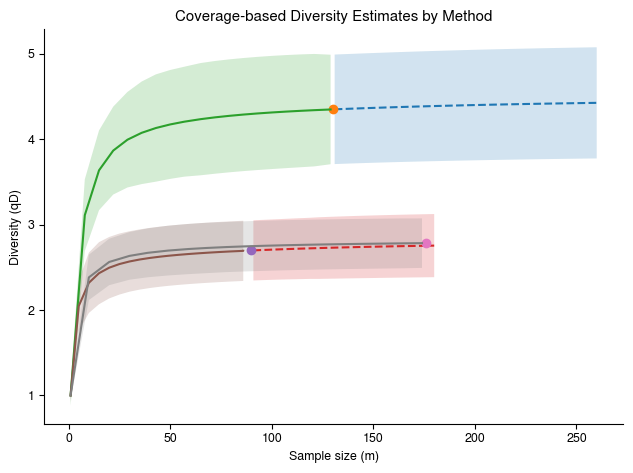

In [27]:
fig, ax = plt.subplots()

method_styles = {
    "Rarefaction": {"linestyle": "-", "marker": ""},
    "Observed": {"linestyle": "None", "marker": "o"},
    "Extrapolation": {"linestyle": "--", "marker": ""}
}

q = 1

df_q = coverage_est[coverage_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    for method, mdf in subdf.groupby("Method"):
        style = method_styles.get(method, {"linestyle": "-", "marker": ""})
        ax.plot(
            mdf["m"], mdf["qD"],
            label=f"{assemblage}, q={q}, {method}",
            **style
        )
        ax.fill_between(
            mdf["m"], mdf["qD.LCL"], mdf["qD.UCL"],
            alpha=0.2
        )

ax.set_xlabel("Sample size (m)")
ax.set_ylabel("Diversity (qD)")
ax.set_title("Coverage-based Diversity Estimates by Method")
# ax.legend()
plt.tight_layout()

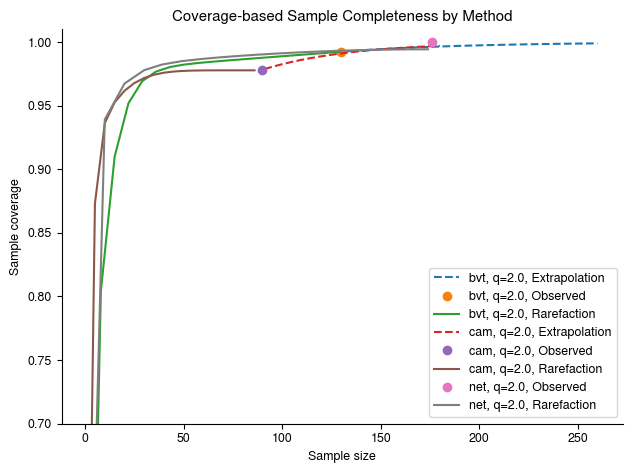

In [28]:
fig, ax = plt.subplots()

method_styles = {
    "Rarefaction": {"linestyle": "-", "marker": ""},
    "Observed": {"linestyle": "None", "marker": "o"},
    "Extrapolation": {"linestyle": "--", "marker": ""}
}

q = 2
df_q = coverage_est[coverage_est["Order.q"] == q]

for (assemblage, q), subdf in df_q.groupby(["Assemblage", "Order.q"]):
    for method, mdf in subdf.groupby("Method"):
        style = method_styles.get(method, {"linestyle": "-", "marker": ""})
        ax.plot(
            mdf["m"], mdf["SC"],
            label=f"{assemblage}, q={q}, {method}",
            **style
        )
        if "SC.LCL" in mdf and "SC.UCL" in mdf:
            ax.fill_between(
                mdf["m"], mdf["SC.LCL"], mdf["SC.UCL"],
                alpha=0.2
            )

ax.set_xlabel("Sample size")
ax.set_ylabel("Sample coverage")
ax.set_title("Coverage-based Sample Completeness by Method")
ax.set_ylim(0.7, 1.01)
# ax.set_xlim(0, 300)
ax.legend()
plt.tight_layout()